# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 4. Нейронные сети.


In [3]:
import numpy as np
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

sns.set(font_scale=1.2, palette='Set2')
%matplotlib inline

---
### <font color="blue"><i>Легкая часть</i></font>

---
### Задача 1.

Рассмотрим двухслойную нейронную сеть, которая принимает на вход $x\in\mathbb{R}$ и возвращает $y\in\mathbb{R}$. Выход первого слоя возвращает $u \in\mathbb{R}^2$. После первого слоя используется функция активации $\sigma(x) = \frac{1}{1 + \exp(-x)}$, после второго слоя функция активации не используется (или используется тождественная). Тем самым нашу нейронную можно представить в виде

$$\widehat{y}(x) = \sum_{h=1}^2 w_{2h}u_h(x) + b_2,$$

$$u_h(x) = \sigma(w_{1h}x + b_{1h}),$$

$$\text{где} \; h \in \{1, 2\}.$$



**1.** Нарисуйте схематически данную нейронную сеть. Сколько у нее обучаемых параметров?

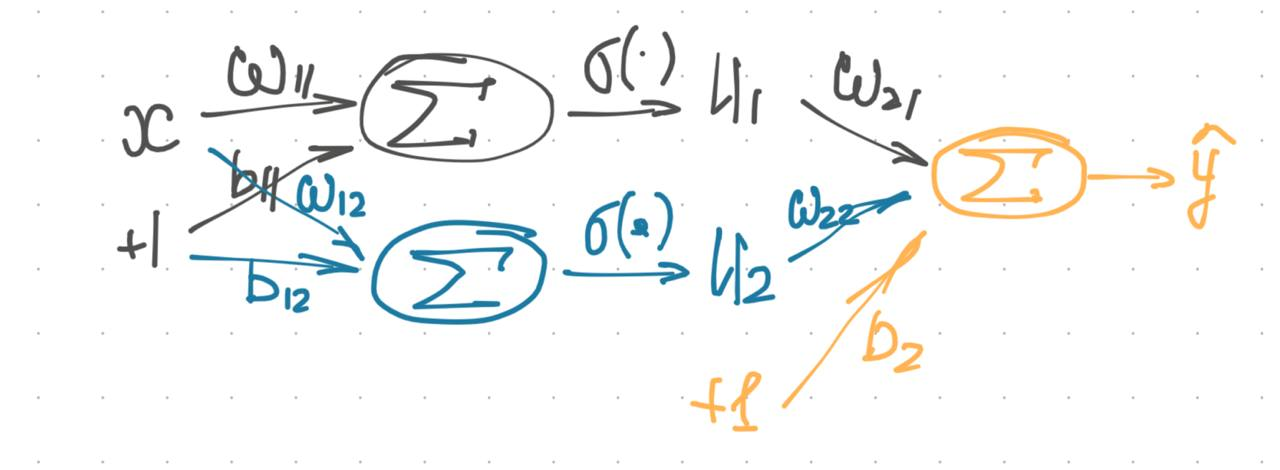

In [2]:
from IPython.display import Image
Image(filename='hw4_scheme.jpg')

У модели $\omega_{11}$, $\omega_{12}$, $b_{11}$, $b_{12}$, $\omega_{21}$, $\omega_{21}$, $b_2$ = 7 обучаемых параметров.

**2.** Пусть нам дана обучающая выборка $(X_1, Y_1), ..., (X_n, Y_n)$, где $X_i \in \mathbb{R}$ и $Y_i \in \mathbb{R}$. Нейронная сеть обучается по этой выборке, минимизируя заданную функцию $L$ &mdash; функцию ошибки. Положим, что $L$ &mdash; это MSE:
$$\text{MSE} = L(X, Y) = \frac{1}{n}\sum_{i=1}^n \big(Y_i - \widehat{y}(X_i)\big)^2.$$

Наша задача &mdash; найти оптимальные параметры нашей модели для минимизации $L(X, Y)$ на заданном наборе данных. Мы будем решать эту задачу с помощью градиентного спуска. Для этого нам понадобится выписать производные по всем параметрам сети. Конечно, в данном случае довольно просто выписать все производные напрямую. Однако мы воспользуемся следующей хитростью: мы будем считать производные поэтапно, причем начнем с конца вычислительной цепочки и, используя формулу производной сложной функции, последовательно посчитаем все необходимые производные. Этот процесс называется методом **обратного распространения ошибки (backpropagation)**.

**2.1.** Начнем с производной MSE по выходам сети
$$\frac{\partial\:\text{MSE}}{\partial \widehat{y}(X_i)} = \frac{2}{n}\sum_{i=1}^n \big(\widehat{y}(X_i) - Y_i \big)$$

**2.2** Возьмем производные выходов сети по параметрам последнего слоя

$$\frac{\partial \widehat{y}(X_i)}{\partial w_{2h}} = u_h(X_i)$$

$$\frac{\partial \widehat{y}(X_i)}{\partial b_2} = 1$$

Также выпишем производные выходов сети по входам последнего слоя

$$\frac{\partial \widehat{y}(X_i)}{\partial u_h(X_i)} = \omega_{2h}^T$$

Теперь выпишем производные MSE по параметрам и входам последнего слоя. Для этого вспомните правило производной сложной функции из математического анализа. Обратите внимание на то, что нам не нужно прописывать все производные до конца, достаточно заполнить пропуски в записи ниже:

$$\frac{\partial\:\text{MSE}}{\partial w_{2h}} = \sum_{i=1}^n \frac{\partial\:\text{MSE}}{\partial \widehat{y}(X_i)} \frac{\partial \widehat{y}(X_i)}{\partial w_{2h}}$$

$$\frac{\partial\:\text{MSE}}{\partial b_2} = \sum_{i=1}^n \frac{\partial\:\text{MSE}}{\partial \widehat{y}(X_i)} \frac{\partial \widehat{y}(X_i)}{\partial b_2}$$

$$\frac{\partial\:\text{MSE}}{\partial u_h} = \sum_{i=1}^n \frac{\partial\:\text{MSE}}{\partial \widehat{y}(X_i)} \frac{\partial \widehat{y}(X_i)}{\partial u_h}$$

**2.2.** Теперь будем разбираться с производными по параметрам первого слоя.

Для начала нам пригодится производная функции активации, запишите ее так, чтобы ответе осталась функция от $\sigma(x)$

$$\frac{\partial\:\sigma(x)}{\partial x} = \sigma(x) - \sigma^2(x)$$

Теперь возьмем производные выходов первого слоя по его параметрам

$$\frac{\partial u_h(X_i)}{\partial w_{1h}} = X_i (u_h(X_i) - u_h^2(X_i))$$

$$\frac{\partial u_h(X_i)}{\partial b_{1h}} = u_h(X_i) - u_h^2(X_i)$$

Наконец, выпишем производные MSE по параметрам первого слоя. Так же как и раньше достаточно заполнить пропуски в записи ниже

$$\frac{\partial\:\text{MSE}}{\partial w_{1h}} = \; \sum_{i=1}^n \frac{\partial\:\text{MSE}}{\partial u_h} \frac{\partial u_h}{\partial w_{1h}}$$

$$\frac{\partial\:\text{MSE}}{\partial b_{1h}} = \; \sum_{i=1}^n \frac{\partial\:\text{MSE}}{\partial u_h} \frac{\partial u_h}{\partial b_{1h}}$$

**3.** Пусть обучающая выборка очень большая. Что нужно делать в таком случае? Запишите, как нужно поменять правило обновления параметров.

В таком случае надо обучаться не по всему датасету, а брать лишь какую-то часть от него. Т.е. надо применять стохастический градиентный спуск.

$$\theta_{t} = \theta_{t-1} - \eta\nabla(\frac{1}{B}\sum_{b=1}^B\mathbb{L}(\widehat{y}_{\theta_{t-1}}(x_{i_b}), Y_{i_b}))$$

Для каждого блока считаем градиент и обновляем параметры. $(x_{i_1}, ..., x_{i_B})$ - текущий батч.

**Вывод:**
Данный пример показывает, что градиенты выражаются друг через друга, если идти в порядке от последних к первым. Кроме того, мы поняли, что оптимальное значение параметров можно находить с помощью градиентного спуска. А если же обучающая выборка очень большая, то стоит воспользоваться его модификацией: стохастическим градиентным спуском.

---
### Задача 2.

Напишем нейронную сеть из задачи 1 с помощью библиотеки `pytorch`, используя Sequential-стиль. Функция активации реализована как `torch.nn.Sigmoid`.

In [4]:
model = nn.Sequential(
    nn.Linear(in_features=1, out_features=2),
    nn.Sigmoid(),
    nn.Linear(in_features=2, out_features=1)
)

Сгенерируем данные. Возьмем какую-либо нелинейную функцию $y(x)$.

In [5]:
sample_size = int(1e6)
X = torch.tensor(sps.norm.rvs(size=(sample_size, 1))).float()
y = torch.tensor(X**3).reshape(sample_size).float()

assert y.shape == (sample_size,)

/tmp/ipykernel_11632/36598299.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(X**3).reshape(sample_size).float()


Обучим нейросеть на этих данных. Используем код с занятия.

In [6]:
data = torch.cat([X, y.reshape(-1, 1)], axis=1)
train, test = train_test_split(data, train_size=0.9)

Установим скорость обучения `lr = 0.01`.

In [7]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
optim_func = nn.MSELoss()

for epoch in range(50):
    for batch in DataLoader(train, batch_size=128):
        x_batch = batch[:, 0].reshape(-1, 1)
        y_batch = batch[:, 1]
        # Forward pass: предсказание модели по данным x_new
        y_pred = model(x_batch)

        # Вычисление оптимизируемой функции (MSE) по предсказаниям
        loss = optim_func(y_pred, y_batch.reshape(-1, 1))

        # Bakcward pass: вычисление градиентов оптимизируемой функции
        # по всем параметрам модели
        loss.backward()

        # Оптимизация: обновление параметров по формулам соответствующего
        # метода оптимизации, используются вычисленные ранее градиенты
        optimizer.step()

        # Зануление градиентов
        optimizer.zero_grad()

Визуализируем предсказания и посчитаем MSE на тестовой части данных.

MSE считаем лишь по части данных, так как иначе происходит `memory limit`.

In [8]:
# MSE
print(optim_func(model(test[:50000, 0].reshape(-1, 1)), test[:50000, 1]).item())

/home/daniil/anaconda3/envs/mipt-stats/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([50000])) that is different to the input size (torch.Size([50000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


29.68007469177246


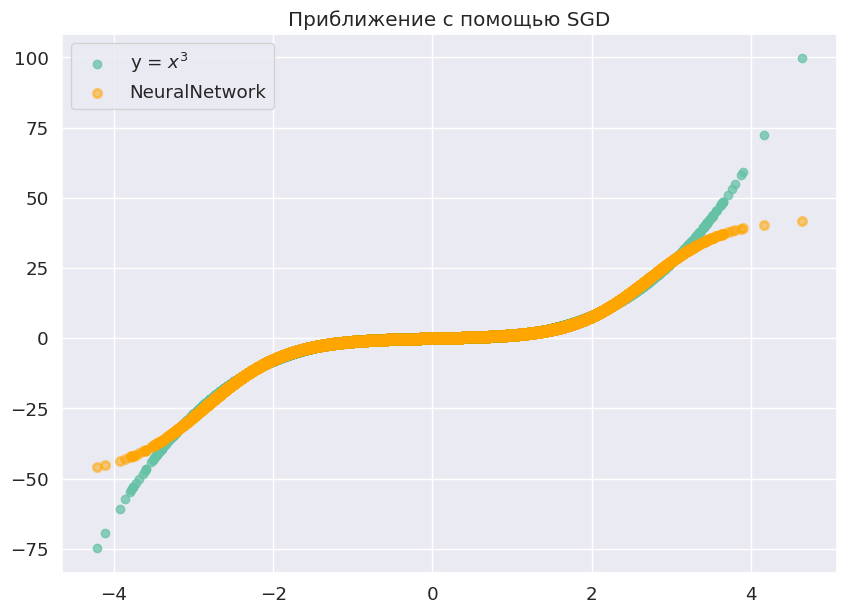

In [9]:
plt.figure(figsize=(10, 7))
plt.scatter(test[:, 0], test[:, 1], alpha=0.75)
plt.scatter(test[:, 0], model(test[:, 0].reshape(-1, 1)).detach(), color='orange', linewidth=2, alpha=0.5)
plt.legend(['y = $x^3$', 'NeuralNetwork'])
plt.title('Приближение с помощью SGD')
plt.show()

**Вывод:**
Библиотека PyTorch позволяет сконцентрировать внимание на работе с NN, скрывая математические подробности за польовательским интерфейсом. 

Видим, что нейросеть достаточно хорошо приблизила функцию, при этом на концах отклонение достачно большое. Это говорит о том, что она не успела обучиться на данных, соответствующих краевым точкам.

---
### <font color="orange"><i>Сложная часть</i></font>

---
### Задача 3.

Теперь реализуйте класс нейронной сети из задачи 1 в стиле scikit-learn. Предусмотрим возможность обучения по случайным батчам. При реализации можно использовать только библиотеку `numpy`.

In [10]:
class NeuralNetwork:
    def __init__(self, lr = 0.01, batch_size = 0):
        '''
        Инициализация модели.
        
        Аргументы:
        X -- датасет для понимания размерности.
        lr -- скорость обучения.
        batch_size -- размер батча.
        '''
        # зададим значения параметров
        self.w1h = np.random.rand(1, 2)
        self.b1h = np.random.rand(1, 2)
        self.w2h = np.random.rand(2, 1)
        self.b2 = np.random.rand()
        self.lr = lr
        self.batch_size = batch_size

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-1 * x))

    def forward_pass(self, x):
        u = self.sigmoid(np.reshape(x, (1, 1)) @ self.w1h + self.b1h)   #(1, 2)
        return u @ self.w2h + self.b2

    def backward_pass(self, X, Y, y_pred):
        # sigma
        u = self.sigmoid(np.reshape(X, (X.shape[0], 1)) @ self.w1h + self.b1h)

        #dL/dY_i
        # print(Y.shape, y_pred.shape)
        dY_i = (2 / self.batch_size) * (y_pred - Y)
        # dY_i = np.reshape(dY_i, (dY_i.shape[0], 1))

        #dL/dw_1h
        dw_1h = (dY_i * X).T @ (u - u**2) * self.w2h.T
        dw_1h = np.reshape(dw_1h, (1, 2))
        #dL/db_1h
        db_1h = dY_i.T @ (u - u**2)
        db_1h = np.reshape(db_1h, (1, 2))
        #dL/dw_2h
        dw_2h = (dY_i.T @ u).T
        dw_2h = np.reshape(dw_2h, (2, 1))
        #dL/db_2
        db_2 = (dY_i).sum()

        self.w1h -= self.lr * dw_1h
        self.b1h -= self.lr * db_1h
        self.w2h -= self.lr * dw_2h
        self.b2 -= self.lr * db_2

    def fit(self, data):
        '''
        Обучение модели: на каждой эпохе forward pass + backward pass.
        
        Аргументы:
        data - входные данные для обучения
        '''
        for _ in range(10):
            np.random.shuffle(data)
            X_ = data[:, 0]
            Y_ = data[:, 1]
            for i in range(0, X_.shape[0], self.batch_size):
                # temp_indx = np.random.choice(np.arange(X_.shape[0]), size=self.batch_size)
                X = X_[i : i + self.batch_size]
                Y = Y_[i : i + self.batch_size]

                y_pred = np.squeeze(np.array([self.forward_pass(x) for x in X]))
                self.backward_pass(X, Y, y_pred)
    
    def predict(self, X_):
        '''
        Вычисление предсказаний.
        
        Аргументы:
        X -- numpy-матрица объект-признак размера (n, d);
        
        Возвращает:
        predictions -- предсказания в виде numpy-вектора размера (n,).
        '''
        y_pred = [self.forward_pass(x) for x in X_]
        
        return y_pred

Обучим нейронную сеть на рассмотренных ранее данных, а также простую линейную регрессию. Для линейной регрессии стоит взять реализацию из `sklearn`. Сравним эту нейросеть, линейную регрессию и pytorch-сеть из задачи 2.

In [11]:
sample_size = int(1e6)
X = sps.norm.rvs(size=(sample_size, 1))
y = (X ** 3).reshape(sample_size)

assert y.shape == (sample_size,)

In [12]:
data = np.concatenate([X, y.reshape(-1, 1)], axis=1)
train, test = train_test_split(data, train_size=0.9)

In [13]:
model2 = NeuralNetwork(batch_size=256)
model2.fit(train)
linear_model = LinearRegression().fit(train[:, 0].reshape(-1, 1), train[:, 1].reshape(-1, 1))

Сравним сети между собой. Визуализируем предсказания данных моделей и посчитаем MSE на тестовой части данных.

В силу ограничения вычислительных мощностей MSE считаем лишь по половине данных.

In [14]:
model2_pred = np.squeeze(model2.predict(test[:, 0].reshape(-1, 1)))
pytorch_pred = model(torch.tensor(test[:, 0].reshape(-1, 1)).float())
pytorch_test = torch.tensor(test[:, 0]).float()
linear_pred = linear_model.predict(test[:, 0].reshape(-1, 1))

print(f'MSE каждой модели:\n'\
        f'Собственная NN: {round(mean_squared_error(model2_pred[:50000], test[:50000, 1]), 3)}\n'\
        f'PyTorch-model: {round(optim_func(pytorch_pred[:50000], pytorch_test[:50000]).item(), 3)}\n'\
        f'Linear: {round(mean_squared_error(linear_pred[:50000], test[:50000, 1].reshape(-1, 1)), 3)}\n')

/home/daniil/anaconda3/envs/mipt-stats/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([50000])) that is different to the input size (torch.Size([50000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSE каждой модели:
Собственная NN: 0.752
PyTorch-model: 13.987
Linear: 5.346



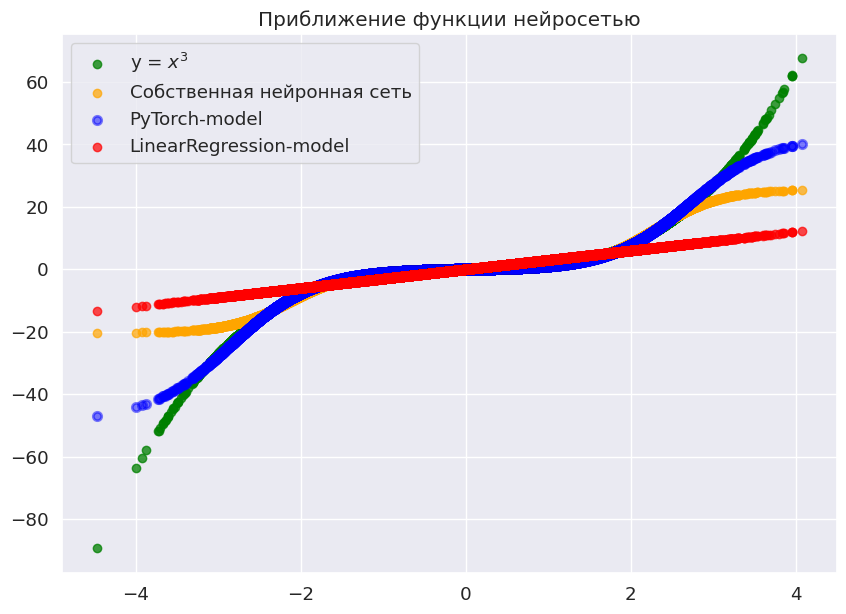

In [15]:
plt.figure(figsize=(10, 7))
plt.scatter(test[:, 0], test[:, 1], color='green', alpha=0.75)
plt.scatter(test[:, 0], model2_pred.T, color='orange', alpha=0.7)
plt.scatter(test[:, 0], pytorch_pred.detach().numpy(), color='blue', linewidth=2, alpha=0.5)
plt.scatter(test[:, 0], linear_pred, color='red', alpha=0.7)
plt.legend(['y = $x^3$', 'Собственная нейронная сеть', 'PyTorch-model', 'LinearRegression-model'])
plt.title('Приближение функции нейросетью')
plt.show()

Повторим вычисления для другой нелинейной функции $y(x) = x^3 + x^2 - x$.

In [16]:
sample_size = int(1e6)
X = sps.norm.rvs(size=(sample_size, 1))
y = (X ** 3 + X ** 2 - X).reshape(sample_size)

assert y.shape == (sample_size,)

In [17]:
data = np.concatenate([X, y.reshape(-1, 1)], axis=1)
train_np, test_np = train_test_split(data, train_size=0.9)
train_torch, test_torch = torch.tensor(train_np).float(), torch.tensor(test_np).float()

In [18]:
model2 = NeuralNetwork(batch_size=256)
model2.fit(train_np)
linear_model = LinearRegression().fit(X, y)

In [19]:
model = nn.Sequential(
    nn.Linear(in_features=1, out_features=2),
    nn.Sigmoid(),
    nn.Linear(in_features=2, out_features=1)
)

optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
optim_func = nn.MSELoss()

for epoch in range(50):
    for batch in DataLoader(train_torch, batch_size=128):
        x_batch = batch[:, 0].reshape(-1, 1)
        y_batch = batch[:, 1]
        # Forward pass: предсказание модели по данным x_new
        y_pred = model(x_batch)

        # Вычисление оптимизируемой функции (MSE) по предсказаниям
        loss = optim_func(y_pred, y_batch.reshape(-1, 1))

        # Bakcward pass: вычисление градиентов оптимизируемой функции
        # по всем параметрам модели
        loss.backward()

        # Оптимизация: обновление параметров по формулам соответствующего
        # метода оптимизации, используются вычисленные ранее градиенты
        optimizer.step()

        # Зануление градиентов
        optimizer.zero_grad()

In [20]:
model2_pred = np.squeeze(model2.predict(test[:, 0].reshape(-1, 1)))
pytorch_pred = model(torch.tensor(test[:, 0].reshape(-1, 1)).float())
pytorch_test = torch.tensor(test[:, 0]).float()
linear_pred = linear_model.predict(test[:, 0].reshape(-1, 1))

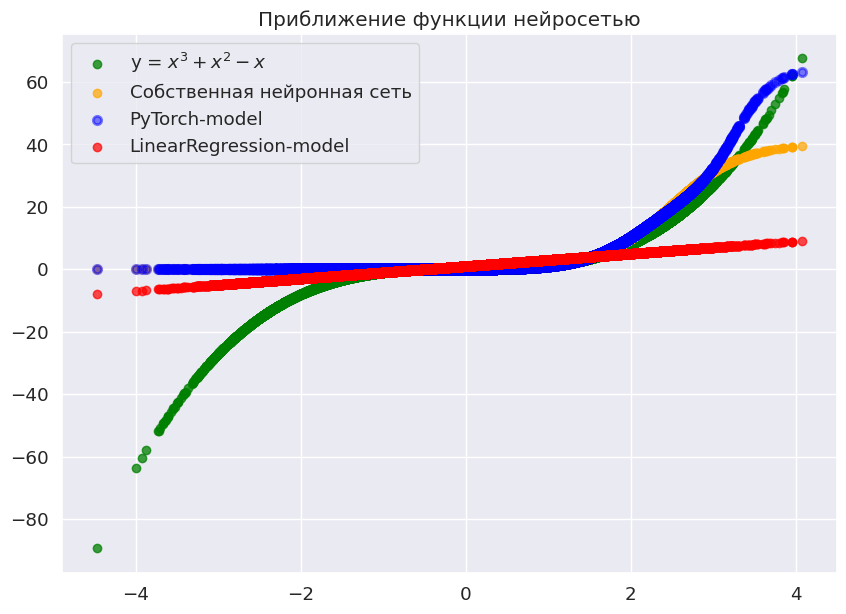

In [21]:
plt.figure(figsize=(10, 7))
plt.scatter(test[:, 0], test[:, 1], color='green', alpha=0.75)
plt.scatter(test[:, 0], model2_pred.T, color='orange', alpha=0.7)
plt.scatter(test[:, 0], pytorch_pred.detach().numpy(), color='blue', linewidth=2, alpha=0.5)
plt.scatter(test[:, 0], linear_pred, color='red', alpha=0.7)
plt.legend(['y = $x^3 + x^2 - x$', 'Собственная нейронная сеть', 'PyTorch-model', 'LinearRegression-model'])
plt.title('Приближение функции нейросетью')
plt.show()

**Вывод:**
Через проделанную работу мы поняли работу простейших нейронных сетей:
* поработали с методом `backward pass` для поиска градиентов
* написали две версии нейронной сети: сначала воспользовались библиотекой `PyTorch`, а потом погрузились в математическую сторону реализации, написав модель, используя только `numpy`.
* Убедились на двух нелинейных функциях, что модели, основанные на нейронных сетях успешно их приближают, когда как линейные не справляются.